# DB API - first look

In [265]:
import pandas as pd
import pyhafas
import datetime as dt
import time
import pytz

from pyhafas import HafasClient
from pyhafas.profile import VSNProfile
from pyhafas.types.fptf import Leg
from datetime import datetime
from datetime import timedelta
from typing import List
from pyhafas.profile import DBProfile
from pyhafas.types.fptf import Leg


### The API operates with "journeys", which are classes representing a trip from origin to destination. In each trip there are legs, representing the number of train changes. You can specify a number of conditions for each journey

In [6]:
client = HafasClient(VSNProfile())

date_time_str = '18/09/22 01:55:19' # you can play around with date and time, but looks like it only looks into the future
date_time_obj = datetime.strptime(date_time_str, '%d/%m/%y %H:%M:%S')
    
origin = client.locations("München Hbf")[0]
connections = client.locations("Mannheim")[0] # can specify here whether you want a connection 
destination = client.locations("Köln Messe")[0]

journeys = client.journeys(
    origin=origin,
    via=[connections],
    destination=destination,
    date=date_time_obj,#datetime.datetime.now(),
    max_changes=2, # we can delimit here how many changes we want to work with
    min_change_time=1,
    max_journeys=-1,
        products={
        'long_distance_express': True,
        'regional_express': False,
        'regional': False,
        'suburban': False,
        'bus': False,
        'ferry': False,
        'subway': False,
        'tram': False,
        'taxi': False
    }

)
    
#journey = client.journey(journeys[0].id)

print('Journey 1 - direct Munich to Cologne')
print(journeys[0].legs[0].name)
print(journeys[0].legs[0].origin.name)
print(journeys[0].legs[0].destination.name)
print('\n')
print('Journey 2 - Munich to Cologne with stop in Mannheim and Frankfurt Flughafen')
print(journeys[2].legs[0].name)
print(journeys[2].legs[0].origin.name)
print(journeys[2].legs[0].destination.name)
print(journeys[2].legs[1].name)
print(journeys[2].legs[1].origin.name)
print(journeys[2].legs[1].destination.name)
print(journeys[2].legs[2].name)
print(journeys[2].legs[2].origin.name)
print(journeys[2].legs[2].destination.name)

Journey 1 - direct Munich to Cologne
ICE 616
München Hbf
Köln Hbf


Journey 2 - Munich to Cologne with stop in Mannheim and Frankfurt Flughafen
ICE 692
München Hbf
Mannheim Hbf
ICE 202
Mannheim Hbf
Frankfurt(Main) Flughafen Fernbf
ICE 728
Frankfurt(Main) Flughafen Fernbf
Köln Messe/Deutz Gl.11-12


## Overview

The "legs" class also has some extra info like expected arrival time and coordinates. Particularly the latter could be useful for plotting

In [7]:
print('Station 1')
print(journeys[2].legs[0].origin.name)
print(journeys[2].legs[0].origin.latitude)
print(journeys[2].legs[0].origin.longitude)

print('\nStation 2')
print(journeys[2].legs[1].origin.name)
print(journeys[2].legs[1].origin.latitude)
print(journeys[2].legs[1].origin.longitude)

print('\nStation 3')
print(journeys[2].legs[2].origin.name)
print(journeys[2].legs[2].origin.latitude)
print(journeys[2].legs[2].origin.longitude)

print('\nStation 4')
print(journeys[2].legs[2].destination.name)
print(journeys[2].legs[2].destination.latitude)
print(journeys[2].legs[2].destination.longitude)


Station 1
München Hbf
48.140229
11.558339

Station 2
Mannheim Hbf
49.479352
8.468917

Station 3
Frankfurt(Main) Flughafen Fernbf
50.053169
8.570181

Station 4
Köln Messe/Deutz Gl.11-12
50.941717
6.974065


## Basic plotting

In [11]:
import folium

lat = [journeys[2].legs[0].origin.latitude, journeys[2].legs[1].origin.latitude, journeys[2].legs[2].origin.latitude, journeys[2].legs[2].destination.latitude]
lon = [journeys[2].legs[0].origin.longitude, journeys[2].legs[1].origin.longitude, journeys[2].legs[2].origin.longitude, journeys[2].legs[2].destination.longitude]
coords = list(zip(lat,lon))


m = folium.Map(location=coords[1], zoom_start=6, tiles='Cartodb dark_matter')

aline=folium.PolyLine(locations=coords,weight=2,color = 'blue')
m.add_child(aline)

for i in coords:
    folium.CircleMarker(location=[i[0], i[1]],
                        radius=2,
                        color='#00C4B3',
                        fill_color='#00C4B3',
                        fill=True).add_to(m)

# We can add a different journey to see the difference
date_time_str = '18/09/22 01:55:19' # you can play around with date and time, but looks like it only looks into the future
date_time_obj = datetime.strptime(date_time_str, '%d/%m/%y %H:%M:%S')
    
origin = client.locations("München Hbf")[0]
connections = client.locations("Nürnberg")[0] # different path
destination = client.locations("Köln Messe")[0]


journeys2 = client.journeys(
    origin=origin,
    via=[connections],
    destination=destination,
    date=date_time_obj,#datetime.datetime.now(),
    max_changes=2,
    min_change_time=1,
    max_journeys=-1,
        products={
        'long_distance_express': True,
        'regional_express': False,
        'regional': False,
        'suburban': False,
        'bus': False,
        'ferry': False,
        'subway': False,
        'tram': False,
        'taxi': False
    }

)

lat2 = [journeys2[3].legs[0].origin.latitude, journeys2[3].legs[1].origin.latitude, journeys2[3].legs[1].destination.latitude]
lon2 = [journeys2[3].legs[0].origin.longitude, journeys2[3].legs[1].origin.longitude, journeys2[3].legs[1].destination.longitude]
coords2 = list(zip(lat2,lon2))

aline=folium.PolyLine(locations=coords2,weight=2,color = 'red')
m.add_child(aline)

for i in coords2:
    folium.CircleMarker(location=[i[0], i[1]],
                        radius=2,
                        color='red',
                        fill_color='red',
                        fill=True).add_to(m)


m

In [16]:
def journeymaker(dateandtime,origin,destination):
    journey = client.journeys(
    origin=origin,
    destination=destination,
    date=dateandtime,
    max_changes=2,
    min_change_time=5,
    max_journeys=-1,
        products={
        'long_distance_express': True,
        'regional_express': False,
        'regional': False,
        'suburban': False,
        'bus': False,
        'ferry': False,
        'subway': False,
        'tram': False,
        'taxi': False
    })
    return journey


In [17]:

journeylist = []
#connection1 = []
#connection2 = []
dateandtime0 = '04/09/22 02:00:00' 
dateandtime = datetime.strptime(dateandtime0, '%d/%m/%y %H:%M:%S')
origin = client.locations("München Hbf")[0]
destination = client.locations("Köln Hbf")[0]
daylimit = dateandtime.day + 7

while dateandtime.day < daylimit:
    tempjourneys = journeymaker(dateandtime,origin,destination)
    dateandtime = tempjourneys[-1].legs[0].departure + timedelta(minutes = 1) # this is the departure time of the last trip the API gave us, we are adding a minute to it to get more 
    print(f'Fetching trains from this date: {dateandtime}')
    for journey in tempjourneys:
        journeylist.append(journey)
    time.sleep(1) #just so we don't go over the API limit

Fetching trains from this date: 2022-09-04 06:30:00+02:00
Fetching trains from this date: 2022-09-04 07:47:00+02:00
Fetching trains from this date: 2022-09-04 09:29:00+02:00
Fetching trains from this date: 2022-09-04 12:28:00+02:00
Fetching trains from this date: 2022-09-04 14:28:00+02:00
Fetching trains from this date: 2022-09-04 16:28:00+02:00
Fetching trains from this date: 2022-09-04 18:17:00+02:00
Fetching trains from this date: 2022-09-04 19:29:00+02:00
Fetching trains from this date: 2022-09-05 04:28:00+02:00
Fetching trains from this date: 2022-09-05 06:47:00+02:00
Fetching trains from this date: 2022-09-05 08:47:00+02:00
Fetching trains from this date: 2022-09-05 11:29:00+02:00
Fetching trains from this date: 2022-09-05 13:29:00+02:00
Fetching trains from this date: 2022-09-05 15:29:00+02:00
Fetching trains from this date: 2022-09-05 18:17:00+02:00
Fetching trains from this date: 2022-09-05 19:29:00+02:00
Fetching trains from this date: 2022-09-06 04:28:00+02:00
Fetching train

In [20]:

journeylist_berlin_kolnhbf = []
#connection1 = []
#connection2 = []
dateandtime0 = '04/09/22 02:00:00' 
dateandtime = datetime.strptime(dateandtime0, '%d/%m/%y %H:%M:%S')
origin = client.locations("Berlin Hbf")[0]
destination = client.locations("Köln Hbf")[0]
daylimit = dateandtime.day + 7

while dateandtime.day < daylimit:
    tempjourneys = journeymaker(dateandtime,origin,destination)
    dateandtime = tempjourneys[-1].legs[0].departure + timedelta(minutes = 1) # this is the departure time of the last trip the API gave us, we are adding a minute to it to get more 
    print(f'Fetching trains from this date: {dateandtime}')
    for journey in tempjourneys:
        journeylist_berlin_kolnhbf.append(journey)
    time.sleep(1) #just so we don't go over the API limit

Fetching trains from this date: 2022-09-04 06:47:00+02:00
Fetching trains from this date: 2022-09-04 09:47:00+02:00
Fetching trains from this date: 2022-09-04 11:42:00+02:00
Fetching trains from this date: 2022-09-04 13:47:00+02:00
Fetching trains from this date: 2022-09-04 16:48:00+02:00
Fetching trains from this date: 2022-09-04 17:47:00+02:00
Fetching trains from this date: 2022-09-04 19:47:00+02:00
Fetching trains from this date: 2022-09-05 00:22:00+02:00
Fetching trains from this date: 2022-09-05 04:31:00+02:00
Fetching trains from this date: 2022-09-05 06:47:00+02:00
Fetching trains from this date: 2022-09-05 09:47:00+02:00
Fetching trains from this date: 2022-09-05 11:47:00+02:00
Fetching trains from this date: 2022-09-05 13:47:00+02:00
Fetching trains from this date: 2022-09-05 16:48:00+02:00
Fetching trains from this date: 2022-09-05 17:47:00+02:00
Fetching trains from this date: 2022-09-05 19:05:00+02:00
Fetching trains from this date: 2022-09-06 00:22:00+02:00
Fetching train

### Now we can get some information about number of journeys and trains, and also categorize trains according to routes

In [18]:
legs = []
trains = []
changeovers = []

for journey in journeylist:
    for leg in journey.legs:
        legs.append(leg)
        trains.append(leg.name)
        changeovers.append(leg.origin.name)

changeoverset = set(changeovers)
changeoverset.remove(origin.name) # this is the origin station for the whole trip, we don't want to count that as a changeover
  
print(f'Number of journeys: {len(journeylist)}')
print(f'Number of legs: {len(legs)}')
print(f'Number of trains: {len(set(trains))}')
print(f'Which trains: {set(trains)}')
print(f'Stations where trains connect: {changeoverset}')

Number of journeys: 188
Number of legs: 334
Number of trains: 55
Which trains: {'ICE 1010', 'TGV 9576', 'ICE 592', 'ICE 618', 'ICE 614', 'ICE 598', 'ICE 10', 'IC 2014', 'ICE 692', 'ICE 822', 'ICE 580', None, 'ICE 100', 'ICE 108', 'ICE 578', 'ICE 16', 'ICE 200', 'NJ 420', 'ICE 572', 'ICE 612', 'ICE 596', 'ICE 152', 'ICE 514', 'ICE 204', 'ICE 574', 'ICE 102', 'ICE 22', 'ICE 122', 'ICE 1118', 'ICE 524', 'ICE 594', 'ICE 518', 'ICE 202', 'ICE 690', 'IC 2266', 'ICE 106', 'ICE 1164', 'IC 2016', 'ICE 770', 'ICE 254', 'ICE 316', 'ICE 616', 'IC 1298', 'ICE 314', 'IC 1296', 'ICE 918', 'ICE 104', 'ICE 522', 'IC 1910', 'IC 1290', 'ICE 512', 'ICE 590', 'ICE 610', 'ICE 510', 'ICE 516'}
Stations where trains connect: {'Frankfurt(Main) Flughafen Fernbf', 'Würzburg Hbf', 'Köln Messe/Deutz Gl.11-12', 'Mannheim Hbf', 'Stuttgart Hbf', 'Nürnberg Hbf'}


About half of the trips are direct, the rest have 1 or 2 connections

2.0


<AxesSubplot:ylabel='Count'>

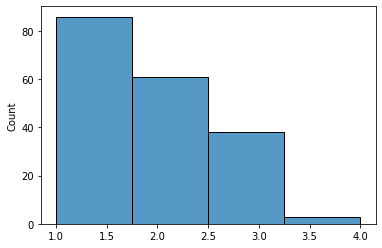

In [220]:
import numpy as np
import seaborn as sns
number_legs = []
for journey in journeylist:
    number_legs.append(len(journey.legs))

print(np.median(number_legs))
sns.histplot(number_legs,bins=4) # some trips have four legs for some reason, even though we set up limits

## Dataframe creation

We now want to extract all possible journeys within a given week and create a dataframe to store the information

In [214]:
# Organize data into lists, create a dataframe and fill it with data from journeys. Bad code, as time lmit was very short

def create_journeydf(journeylist):

    datelist = []
    weekday = []
    month = []
    journey_origin = []
    journey_destination = []
    journey_start = []
    journey_end = []
    journey_duration = []
    journey_numberlegs = []
    leg1_train = []
    leg1_origin = []
    leg1_destination = []
    leg1_start = []
    leg1_end = []
    leg1_duration = []
    leg2_train = []
    leg2_origin = []
    leg2_destination = []
    leg2_start = []
    leg2_end = []
    leg2_duration = []
    leg3_train = []
    leg3_origin = []
    leg3_destination = []
    leg3_start = []
    leg3_end = []
    leg3_duration = []

    for journey in journeylist:
        datelist.append(journey.date)
        weekday.append(journey.date.weekday())
        month.append(journey.date.month)
        journey_origin.append(journey.legs[0].origin.name)
        journey_destination.append(journey.legs[-1].destination.name)
        journey_start.append(journey.legs[0].departure)
        journey_end.append(journey.legs[-1].arrival)
        journey_duration.append(journey.duration.seconds)
        journey_numberlegs.append(len(journey.legs))
        leg1_train.append(journey.legs[0].name)
        leg1_origin.append(journey.legs[0].origin.name)
        leg1_destination.append(journey.legs[0].destination.name)
        leg1_start.append(journey.legs[0].departure)
        leg1_end.append(journey.legs[0].arrival)
        leg1_duration.append((journey.legs[0].arrival - journey.legs[0].departure).seconds)

        if len(journey.legs) == 1:
            leg2_train.append(-1)
            leg2_origin.append(-1)
            leg2_destination.append(-1)
            leg2_start.append(-1)
            leg2_end.append(-1)
            leg2_duration.append(-1)
            leg3_train.append(-1)
            leg3_origin.append(-1)
            leg3_destination.append(-1)
            leg3_start.append(-1)
            leg3_end.append(-1)
            leg3_duration.append(-1)
        elif len(journey.legs) == 2:
            leg2_train.append(journey.legs[1].name)
            leg2_origin.append(journey.legs[1].origin.name)
            leg2_destination.append(journey.legs[1].destination.name)
            leg2_start.append(journey.legs[1].departure)
            leg2_end.append(journey.legs[1].arrival)
            leg2_duration.append((journey.legs[1].arrival - journey.legs[1].departure).seconds)
            leg3_train.append(-1)
            leg3_origin.append(-1)
            leg3_destination.append(-1)
            leg3_start.append(-1)
            leg3_end.append(-1)
            leg3_duration.append(-1)
        elif len(journey.legs) == 3:
            leg2_train.append(journey.legs[1].name)
            leg2_origin.append(journey.legs[1].origin.name)
            leg2_destination.append(journey.legs[1].destination.name)
            leg2_start.append(journey.legs[1].departure)
            leg2_end.append(journey.legs[1].destination.name)
            leg2_duration.append((journey.legs[1].arrival - journey.legs[1].departure).seconds)
            leg3_train.append(journey.legs[2].name)
            leg3_origin.append(journey.legs[2].origin.name)
            leg3_destination.append(journey.legs[2].destination.name)
            leg3_start.append(journey.legs[2].departure)
            leg3_end.append(journey.legs[2].arrival)
            leg3_duration.append((journey.legs[2].arrival - journey.legs[2].departure).seconds)
        elif len(journey.legs) == 4: #there are somehow some trips with four stops, I'm filtering those out later
            leg2_train.append(-1)
            leg2_origin.append(-1)
            leg2_destination.append(-1)
            leg2_start.append(-1)
            leg2_end.append(-1)
            leg2_duration.append(-1)
            leg3_train.append(-1)
            leg3_origin.append(-1)
            leg3_destination.append(-1)
            leg3_start.append(-1)
            leg3_end.append(-1)
            leg3_duration.append(-1)

    journeydf = pd.DataFrame(columns = ['date','weekday','month','journey_origin','journey_destination',
                                        'journey_start','journey_end','journey_duration','journey_numberlegs',
                                        'leg1_train','leg1_origin','leg1_destination','leg1_start','leg1_end','leg1_duration',
                                        'leg2_train','leg2_origin','leg2_destination','leg2_start','leg2_end','leg2_duration',
                                        'leg3_train','leg3_origin','leg3_destination','leg3_start','leg3_end','leg3_duration'])

    journeydf.date = datelist
    journeydf.weekday = weekday
    journeydf.month = month
    journeydf.journey_origin = journey_origin
    journeydf.journey_destination = journey_destination
    journeydf.journey_start = journey_start
    journeydf.journey_end = journey_end                        
    journeydf.journey_duration = journey_duration
    journeydf.journey_numberlegs = journey_numberlegs
    journeydf.leg1_train = leg1_train
    journeydf.leg1_origin = leg1_origin
    journeydf.leg1_destination = leg1_destination
    journeydf.leg1_start = leg1_start
    journeydf.leg1_end = leg1_end
    journeydf.leg1_duration = leg1_duration
    journeydf.leg2_train = leg2_train
    journeydf.leg2_origin = leg2_origin
    journeydf.leg2_destination = leg2_destination
    journeydf.leg2_start = leg2_start
    journeydf.leg2_end = leg2_end
    journeydf.leg2_duration = leg2_duration
    journeydf.leg3_train = leg3_train
    journeydf.leg3_origin = leg3_origin
    journeydf.leg3_destination = leg3_destination
    journeydf.leg3_start = leg3_start
    journeydf.leg3_end = leg3_end
    journeydf.leg3_duration = leg3_duration
    
    journeydf = journeydf.iloc[:-1] # cut the last row, as currently our journeylists are coming with an extra trip at the end
    
    return journeydf


In [215]:
# This is the function output for one example journey

journeydf = create_journeydf(journeylist)

with pd.option_context("display.max_rows", 10, "display.max_columns", None):
  display(journeydf)

,date,weekday,month,journey_origin,journey_destination,journey_start,journey_end,journey_duration,journey_numberlegs,leg1_train,leg1_origin,leg1_destination,leg1_start,leg1_end,leg1_duration,leg2_train,leg2_origin,leg2_destination,leg2_start,leg2_end,leg2_duration,leg3_train,leg3_origin,leg3_destination,leg3_start,leg3_end,leg3_duration
0,2022-09-04,6,9,München Hbf,Köln Hbf,2022-09-04 03:24:00+02:00,2022-09-04 08:05:00+02:00,16860,1,ICE 616,München Hbf,Köln Hbf,2022-09-04 03:24:00+02:00,2022-09-04 08:05:00+02:00,16860,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2022-09-04,6,9,München Hbf,Köln Hbf,2022-09-04 05:33:00+02:00,2022-09-04 10:04:00+02:00,16260,1,ICE 614,München Hbf,Köln Hbf,2022-09-04 05:33:00+02:00,2022-09-04 10:04:00+02:00,16260,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2022-09-04,6,9,München Hbf,Köln Hbf,2022-09-04 06:29:00+02:00,2022-09-04 11:04:00+02:00,16500,2,ICE 692,München Hbf,Mannheim Hbf,2022-09-04 06:29:00+02:00,2022-09-04 09:29:00+02:00,10800,ICE 202,Mannheim Hbf,Köln Hbf,2022-09-04 09:36:00+02:00,2022-09-04 11:04:00+02:00,5280,-1,-1,-1,-1,-1,-1
3,2022-09-04,6,9,München Hbf,Köln Hbf,2022-09-04 06:46:00+02:00,2022-09-04 11:33:00+02:00,17220,3,TGV 9576,München Hbf,Stuttgart Hbf,2022-09-04 06:46:00+02:00,2022-09-04 09:00:00+02:00,8040,ICE 770,Stuttgart Hbf,Frankfurt(Main) Flughafen Fernbf,2022-09-04 09:23:00+02:00,Frankfurt(Main) Flughafen Fernbf,4320,ICE 16,Frankfurt(Main) Flughafen Fernbf,Köln Hbf,2022-09-04 10:42:00+02:00,2022-09-04 11:33:00+02:00,3060
4,2022-09-04,6,9,München Hbf,Köln Hbf,2022-09-04 07:28:00+02:00,2022-09-04 12:05:00+02:00,16620,1,ICE 612,München Hbf,Köln Hbf,2022-09-04 07:28:00+02:00,2022-09-04 12:05:00+02:00,16620,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2022-09-10,5,9,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,1,NJ 420,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
184,2022-09-10,5,9,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,1,NJ 420,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
185,2022-09-10,5,9,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,1,NJ 420,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
186,2022-09-10,5,9,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,1,NJ 420,München Hbf,Köln Hbf,2022-09-10 22:50:00+02:00,2022-09-11 06:51:00+02:00,28860,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [278]:
utc=pytz.UTC # this is needed to localize datetime inputs, so we can compare them

def create_journeylists(listofjourneys,dateandtime): # listofjourneys should contain start and end stations, in that order. dateandtime in datetime format
    
    listofjourneylists = []
    for element in listofjourneys: 
        print(f'Starting to fetch journeys from {element[0]} to {element[1]}')
        journeylist = []
        origin = client.locations(element[0])[0]
        destination = client.locations(element[1])[0]
        startday = dateandtime
        startday = utc.localize(startday) 
        daylimit = startday + timedelta(days=7) # here we can set how many days ahead to check, a complete week makes sense

        while startday < daylimit:
            tempjourneys = journeymaker(startday,origin,destination)
            startday = tempjourneys[-1].legs[0].departure + timedelta(minutes = 1) # this is the departure time of the last trip the API gave us, we are adding a minute to it to get more 
            #startday = utc.localize(startday)
            print(f'Fetching trips starting at {startday}')
            for journey in tempjourneys:
                journeylist.append(journey)
            
            time.sleep(1) #just so we don't go over the API limit
        
        print(f'Finished, fetched {len(journeylist)} journeys')
        listofjourneylists.append(journeylist)
    
    return listofjourneylists

In [279]:
# Now let's iterate through our targets and generate journeylist for each origin-destination pair, and a corresponding df

dateandtime0 = '04/09/22 02:00:00' # the rationale for the date chosen here is to get a "normal" week after summer vacation, starting Sunday
dateandtime = datetime.strptime(dateandtime0, '%d/%m/%y %H:%M:%S')

journeylist_KH_M = ['Köln Hbf', 'München Hbf']
journeylist_KM_M = ['Köln Messe', 'München Hbf']
journeylist_M_KH = ['München Hbf', 'Köln Hbf']
journeylist_M_KM = ['München Hbf', 'Köln Messe']
journeylist_KH_B = ['Köln Hbf', 'Berlin Hbf'] 
journeylist_KM_B = ['Köln Messe','Berlin Hbf']
journeylist_B_KH = ['Berlin Hbf', 'Köln Hbf']
journeylist_B_KM = ['Berlin Hbf', 'Köln Messe']
journeylist_B_M = ['Berlin Hbf', 'München Hbf']
journeylist_M_B = ['München Hbf','Berlin Hbf']

listofjourneys = [journeylist_KH_M,
                  journeylist_KM_M,
                  journeylist_M_KH,
                  journeylist_M_KM] # Let's leave Berlin out for now, we can get those trips later 


listofjourneylists = create_journeylists(listofjourneys,dateandtime)

Starting to fetch journeys from Köln Hbf to München Hbf
Fetching trips starting at 2022-09-04 05:49:00+02:00
Fetching trips starting at 2022-09-04 08:24:00+02:00
Fetching trips starting at 2022-09-04 10:19:00+02:00
Fetching trips starting at 2022-09-04 12:55:00+02:00
Fetching trips starting at 2022-09-04 14:55:00+02:00
Fetching trips starting at 2022-09-04 16:55:00+02:00
Fetching trips starting at 2022-09-04 19:56:00+02:00
Fetching trips starting at 2022-09-05 03:20:00+02:00
Fetching trips starting at 2022-09-05 06:55:00+02:00
Fetching trips starting at 2022-09-05 08:55:00+02:00
Fetching trips starting at 2022-09-05 10:55:00+02:00
Fetching trips starting at 2022-09-05 13:56:00+02:00
Fetching trips starting at 2022-09-05 15:56:00+02:00
Fetching trips starting at 2022-09-05 17:56:00+02:00
Fetching trips starting at 2022-09-05 23:56:00+02:00
Fetching trips starting at 2022-09-06 05:49:00+02:00
Fetching trips starting at 2022-09-06 08:24:00+02:00
Fetching trips starting at 2022-09-06 10:19

Fetching trips starting at 2022-09-05 04:28:00+02:00
Fetching trips starting at 2022-09-05 06:47:00+02:00
Fetching trips starting at 2022-09-05 08:47:00+02:00
Fetching trips starting at 2022-09-05 11:29:00+02:00
Fetching trips starting at 2022-09-05 13:29:00+02:00
Fetching trips starting at 2022-09-05 15:29:00+02:00
Fetching trips starting at 2022-09-05 18:17:00+02:00
Fetching trips starting at 2022-09-05 19:29:00+02:00
Fetching trips starting at 2022-09-06 04:28:00+02:00
Fetching trips starting at 2022-09-06 06:47:00+02:00
Fetching trips starting at 2022-09-06 08:47:00+02:00
Fetching trips starting at 2022-09-06 11:29:00+02:00
Fetching trips starting at 2022-09-06 13:29:00+02:00
Fetching trips starting at 2022-09-06 15:29:00+02:00
Fetching trips starting at 2022-09-06 18:17:00+02:00
Fetching trips starting at 2022-09-06 19:29:00+02:00
Fetching trips starting at 2022-09-07 04:28:00+02:00
Fetching trips starting at 2022-09-07 06:47:00+02:00
Fetching trips starting at 2022-09-07 08:47:00

In [280]:
# Putting it all together in one canonical df

listofdfs = [] # of course we need another list :)

for journeylist in listofjourneylists:
    listofdfs.append(create_journeydf(journeylist))
    
finaldf = pd.concat(listofdfs) 

with pd.option_context("display.max_rows", 10, "display.max_columns", None):
  display(finaldf)

,date,weekday,month,journey_origin,journey_destination,journey_start,journey_end,journey_duration,journey_numberlegs,leg1_train,leg1_origin,leg1_destination,leg1_start,leg1_end,leg1_duration,leg2_train,leg2_origin,leg2_destination,leg2_start,leg2_end,leg2_duration,leg3_train,leg3_origin,leg3_destination,leg3_start,leg3_end,leg3_duration
0,2022-09-04,6,9,Köln Hbf,München Hbf,2022-09-04 04:22:00+02:00,2022-09-04 09:13:00+02:00,17460,2,ICE 521,Köln Hbf,Frankfurt(Main) Flughafen Fernbf,2022-09-04 04:22:00+02:00,2022-09-04 05:26:00+02:00,3840,railje63,Frankfurt(Main) Flughafen Fernbf,München Hbf,2022-09-04 05:39:00+02:00,2022-09-04 09:13:00+02:00,12840,-1,-1,-1,-1,-1,-1
1,2022-09-04,6,9,Köln Hbf,München Hbf,2022-09-04 04:22:00+02:00,2022-09-04 09:39:00+02:00,19020,1,ICE 521,Köln Hbf,München Hbf,2022-09-04 04:22:00+02:00,2022-09-04 09:39:00+02:00,19020,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2022-09-04,6,9,Köln Hbf,München Hbf,2022-09-04 05:48:00+02:00,2022-09-04 10:27:00+02:00,16740,1,ICE 511,Köln Hbf,München Hbf,2022-09-04 05:48:00+02:00,2022-09-04 10:27:00+02:00,16740,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2022-09-04,6,9,Köln Hbf,München Hbf,2022-09-04 06:54:00+02:00,2022-09-04 11:27:00+02:00,16380,2,ICE 101,Köln Hbf,Mannheim Hbf,2022-09-04 06:54:00+02:00,2022-09-04 08:23:00+02:00,5340,ICE 591,Mannheim Hbf,München Hbf,2022-09-04 08:30:00+02:00,2022-09-04 11:27:00+02:00,10620,-1,-1,-1,-1,-1,-1
4,2022-09-04,6,9,Köln Hbf,München Hbf,2022-09-04 07:55:00+02:00,2022-09-04 12:27:00+02:00,16320,1,ICE 513,Köln Hbf,München Hbf,2022-09-04 07:55:00+02:00,2022-09-04 12:27:00+02:00,16320,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,2022-09-10,5,9,München Hbf,Köln Messe/Deutz Gl.11-12,2022-09-10 18:27:00+02:00,2022-09-10 23:21:00+02:00,17640,3,ICE 590,München Hbf,Mannheim Hbf,2022-09-10 18:27:00+02:00,2022-09-10 21:29:00+02:00,10920,ICE 100,Mannheim Hbf,Köln Hbf,2022-09-10 21:36:00+02:00,Köln Hbf,5280,None,Köln Hbf,Köln Messe/Deutz Gl.11-12,2022-09-10 23:04:00+02:00,2022-09-10 23:21:00+02:00,1020
308,2022-09-10,5,9,München Hbf,Köln Messe/Deutz Gl.11-12,2022-09-10 19:28:00+02:00,2022-09-11 00:23:00+02:00,17700,2,ICE 510,München Hbf,Köln Hbf,2022-09-10 19:28:00+02:00,2022-09-11 00:06:00+02:00,16680,None,Köln Hbf,Köln Messe/Deutz Gl.11-12,2022-09-11 00:06:00+02:00,2022-09-11 00:23:00+02:00,1020,-1,-1,-1,-1,-1,-1
309,2022-09-11,6,9,München Hbf,Köln Messe/Deutz Gl.11-12,2022-09-11 00:01:00+02:00,2022-09-11 06:20:00+02:00,22740,2,ICE 618,München Hbf,Köln Hbf,2022-09-11 00:01:00+02:00,2022-09-11 06:03:00+02:00,21720,None,Köln Hbf,Köln Messe/Deutz Gl.11-12,2022-09-11 06:03:00+02:00,2022-09-11 06:20:00+02:00,1020,-1,-1,-1,-1,-1,-1
310,2022-09-11,6,9,München Hbf,Köln Messe/Deutz Gl.11-12,2022-09-11 03:24:00+02:00,2022-09-11 08:22:00+02:00,17880,2,ICE 616,München Hbf,Köln Hbf,2022-09-11 03:24:00+02:00,2022-09-11 08:05:00+02:00,16860,None,Köln Hbf,Köln Messe/Deutz Gl.11-12,2022-09-11 08:05:00+02:00,2022-09-11 08:22:00+02:00,1020,-1,-1,-1,-1,-1,-1


## Dataset integration

In [281]:
df0 = pd.read_csv('../raw_data/select_2020.csv',encoding='iso-8859-2',sep=';')
df1 = pd.read_csv('../raw_data/select_2021.csv',encoding='iso-8859-2',sep=';')
df2 = pd.read_csv('../raw_data/select_2022.csv',encoding='iso-8859-2',sep=';')
df = pd.concat([df0,df1,df2])

# downsample if necessary
#df = df.sample(frac=0.01)

In [290]:
# Not all trains are in our dataset, a problem for later - code below is not working yet, need a little work

trainlist = df.zugnr.unique()
overlappingtrains = [finaldf.leg1_train.unique(),finaldf.leg2_train.unique(),finaldf.leg3_train.unique()]
print(len(set(overlappingtrains)))
print(len(set(trains)))

TypeError: unhashable type: 'numpy.ndarray'

In [297]:
finaldf.to_csv('../data/journeyindex.csv')